## Fuzzy join
All of the joins we have seen so far depend on the key columns being *equal*. However, more general joins are possible. In the next example, we are going to join spatial data such that each point in one table gets joined to its "nearest neighbor" in another table.

### Waffle House

![mmm waaaaafles](https://bloximages.newyork1.vip.townnews.com/redandblack.com/content/tncms/assets/v3/editorial/b/27/b2754cf2-201b-11e8-a237-27bd4fb7f793/5a9ca9a643f3d.image.jpg?resize=640%2C480)

Waffle House is a chain of 24-hour diners located mainly in the southeast. They are known for having very ... rich food.

In [9]:
waffles <- read_csv("geoWaffles.csv") %>% print

Parsed with column specification:
cols(
  full = col_character(),
  lats = col_double(),
  lngs = col_double()
)


# A tibble: 1,889 x 3
   full                                         lats  lngs
   <chr>                                       <dbl> <dbl>
 1 1201 S Quintard Ave, Anniston, AL  36201     33.6 -85.8
 2 1530 Quintard Ave, Anniston, AL  36201       33.7 -85.8
 3 802 Cleveland Ave, Attalla, AL  35954        34.0 -86.1
 4 961 Gilbert Ferry Rd Se, Attalla, AL  35954  34.0 -86.1
 5 110 W Glenn Ave, Auburn, AL  36830           32.6 -85.5
 6 2346 Bent Creek Rd, Auburn, AL  36830        32.6 -85.4
 7 1738 Opelika Rd, Auburn, AL  36830           32.6 -85.4
 8 2167 S College St, Auburn, AL  36832         32.6 -85.5
 9 3998 Methodist Cir, Bessemer, AL  35022      33.3 -86.9
10 5010 Academy Ln, Bessemer, AL  35022         33.4 -87.0
# ... with 1,879 more rows


Using zoom = 5...
Warning message:
“`panel.margin` is deprecated. Please use `panel.spacing` property instead”

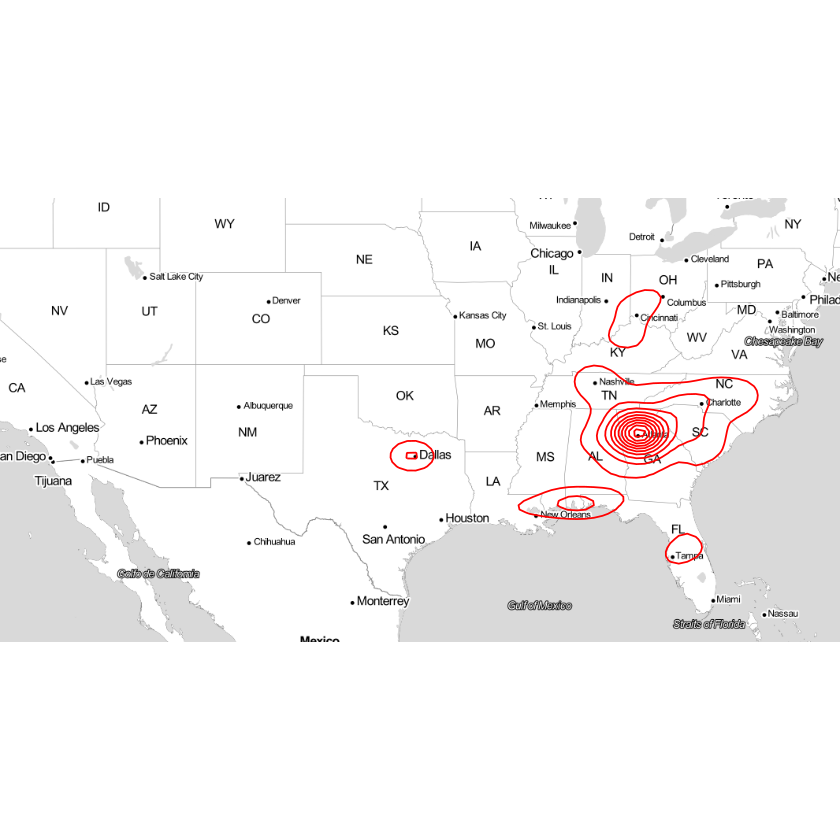

In [23]:
library(ggmap)
qmplot(lngs, lats, data = waffles, maptype = "toner-lite", geom="density2d", color = I("red"))

## Heart disease in the US
The following dataset has statistics for heart disease in the US:

In [25]:
heart <- read_csv("heart_disease.csv")
heart[1,]

Parsed with column specification:
cols(
  Year = col_integer(),
  LocationAbbr = col_character(),
  LocationDesc = col_character(),
  GeographicLevel = col_character(),
  DataSource = col_character(),
  Class = col_character(),
  Topic = col_character(),
  Data_Value = col_double(),
  Data_Value_Unit = col_character(),
  Data_Value_Type = col_character(),
  Data_Value_Footnote_Symbol = col_character(),
  Data_Value_Footnote = col_character(),
  StratificationCategory1 = col_character(),
  Stratification1 = col_character(),
  StratificationCategory2 = col_character(),
  Stratification2 = col_character(),
  TopicID = col_character(),
  LocationID = col_character(),
  `Location 1` = col_character()
)


Year,LocationAbbr,LocationDesc,GeographicLevel,DataSource,Class,Topic,Data_Value,Data_Value_Unit,Data_Value_Type,Data_Value_Footnote_Symbol,Data_Value_Footnote,StratificationCategory1,Stratification1,StratificationCategory2,Stratification2,TopicID,LocationID,Location 1
2015,AK,Aleutians East,County,NVSS,Cardiovascular Diseases,Heart Disease Mortality,110.1,"per 100,000 population","Age-adjusted, Spatially Smoothed, 3-year Average Rate",NA,NA,Gender,Overall,Race/Ethnicity,Overall,T2,02013,"(55.440626, -161.962562)"


In [69]:
table(heart$Topic)
table(heart$Data_Value_Unit)
summary(heart$Data_Value)


Heart Disease Mortality 
                  59076 


per 100,000 population 
                 59076 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    0.0   250.3   336.4   346.3   429.5  5161.7   27177 

The heart disease data also has spatial coordinates but they are stored as strings:

In [26]:
head(heart$`Location 1`)

[1] "(55.440626, -161.962562)" "(52.995403, -170.251538)"
[3] "(61.159049, -149.103905)" "(60.924483, -159.749655)"
[5] "(58.754192, -156.694709)" "(63.678399, -149.962076)"

To convert them to numbers we can use some text processing commands which we'll learn about after the midterm:

In [93]:
heart_pos <- heart %>% mutate(loc = str_match_all(`Location 1`, "\\((-?\\d+\\.\\d+), (-?\\d+\\.\\d+)\\)"),
                       lats = map_dbl(loc, ~ as.numeric(.[[2]])),
                       lngs = map_dbl(loc, ~ as.numeric(.[[3]]))) %>% select(-loc)

We would like to investigate the covariance between a) Waffle House presence and b) heart disease.

To make mapping easier we'll focus on the continental US:

Warning message:
“Removed 18 rows containing missing values (geom_point).”

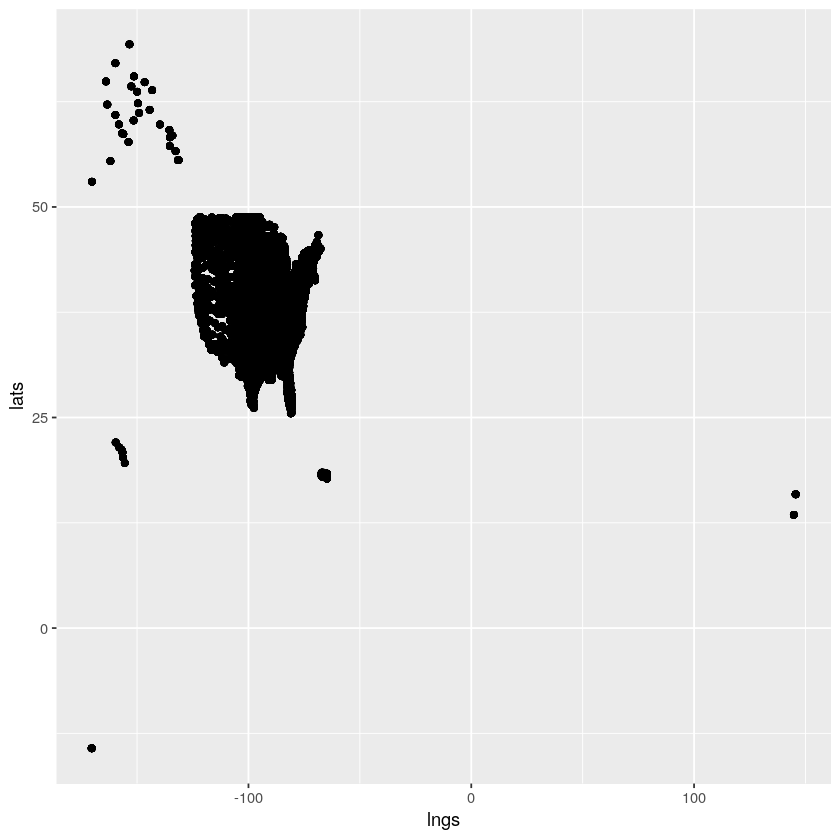

In [86]:
ggplot(heart_pos) + geom_point(aes(x=lngs, y=lats))

Using zoom = 4...
Warning message:
“`panel.margin` is deprecated. Please use `panel.spacing` property instead”Warning message:
“Removed 25231 rows containing missing values (geom_point).”

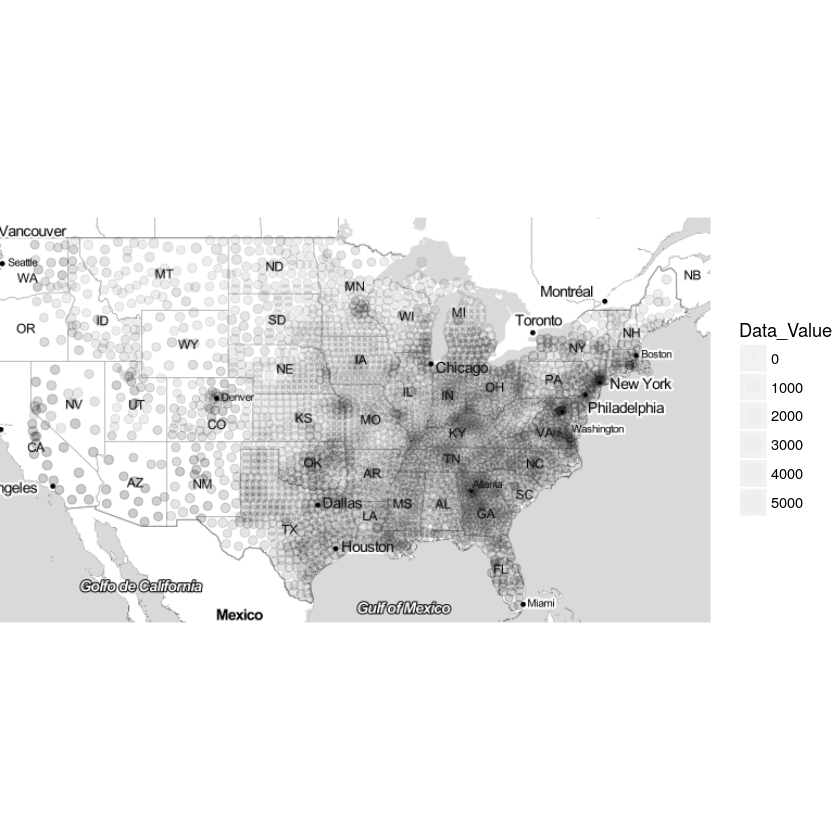

In [108]:
filter(heart_pos, lngs > -120, lngs < 50, lats > 25, lats < 50) %>% 
    qmplot(lngs, lats, data = ., maptype = "toner-lite", geom="point", size=Data_Value,
           alpha=I(.01))

For each Waffle House location, I would like to know the prevalence of heart disease in that area. 
- This is a type of join.
- But not like any we have seen before.
- Cannot join based on equality!

Idea: find points that are "nearby".

In [154]:
# This is a huge table. Do not run!
waffle_heart <- sqldf("
    SELECT waffles.full, 
          (waffles.lats - heart_pos.lats) * (waffles.lats - heart_pos.lats) + 
          (waffles.lngs - heart_pos.lngs) * (waffles.lngs - heart_pos.lngs) as sqdist,
          heart_pos.LocationID, 
          Data_Value as heart_mortality
          FROM heart_pos CROSS JOIN waffles
          WHERE heart_pos.Data_Value IS NOT NULL
") %>% tbl_df

In [155]:
nrow(waffle_heart)
nearest_waffle <- waffle_heart %>% group_by(LocationID) %>% top_n(-1, sqdist)

[1] 60257211

Warning message:
“Removed 1732 rows containing missing values (geom_point).”

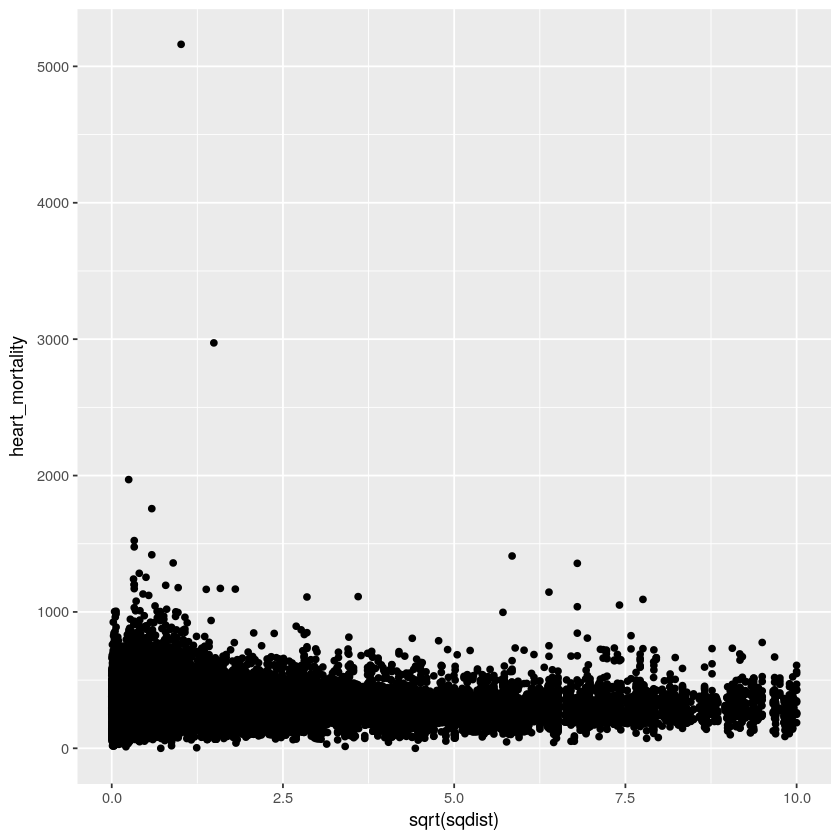

In [160]:
ggplot(nearest_waffle, aes(x=sqrt(sqdist), y=heart_mortality)) + geom_point() + xlim(c(0, 10))